<a id =000> </a> <br>
***

# <center> <span style="color:blue;background:yellow"> [India ML Hiring Hackathon 2019](https://datahack.analyticsvidhya.com/contest/india-ml-hiring-hackathon-2019/) </span></center>

![](images/India_ml.png)

*** 

## Notebook Content
1. [Load Libraries](#0)
1. [Load Data](#1)
1. [OneHotEncoding](#2)
1. [Date columns processing](#3)
1. [Feature Engineering](#4)
1. [LGBM](#5)
    * [Hyperparameters Optimization](#6)
    - [Best Iterations](#7)
    - [Model Training and Prediction](#8)
    - [Submission DataFrame](#9)

#### Read [README](https://github.com/dc-aichara/competitions/tree/master/AV) for more info. 

***

<a id=0> </a> <br>

## <span style="background:gray;color:red">1. </span><span style="background:yellow;color:blue">Load Libraries </span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
import lightgbm as lgb
from bayes_opt import BayesianOptimization

import warnings
warnings.filterwarnings('ignore')

/Users/0030/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


<a id=1> </a> <br>

## <span style="background:gray;color:red">2. </span><span style="background:yellow;color:blue">Load Data </span>

### <center> <span style="color:blue;background:yellow"> Data Dictionary

| Variable | Description |
| ------ | ------ |
|loan_id|Unique loan ID|
|source	|Loan origination channel|
|financial_institution	|Name of the bank|
|interest_rate	|Loan interest rate|
|unpaid_principal_bal	|Loan unpaid principal balance|
|loan_term	|Loan term (in days)|
|origination_date	|Loan origination date (YYYY-MM-DD)|
|first_payment_date	|First instalment payment date |
|loan_to_value	 |Loan to value ratio |
|number_of_borrowers	 |Number of borrowers |
|debt_to_income_ratio	 | Debt-to-income ratio |
|borrower_credit_score	 | Borrower credit score |
|loan_purpose	| Loan purpose |
|insurance_percent	 | Loan Amount percent covered by insurance |
|co-borrower_credit_score	 | Co-borrower credit score |
|insurance_type	 | 0 - Premium paid by borrower, 1 - Premium paid by Lender
|m1 to m12	 | Month-wise loan performance (deliquency in months)　|　
|m13|target, loan deliquency status (0 = non deliquent, 1 = deliquent)　|

In [2]:
# load Data 
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
print('Shape of train Data :', train.shape, '\n Shape of test data :', test.shape)

Shape of train Data : (116058, 29) 
 Shape of test data : (35866, 28)


In [4]:
train.head()

,loan_id,source,financial_institution,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,...,m4,m5,m6,m7,m8,m9,m10,m11,m12,m13
0,268055008619,Z,"Turner, Baldwin and Rhodes",4.250,214000,360,2012-03-01,05/2012,95,1.0,...,0,0,0,1,0,0,0,0,0,1
1,672831657627,Y,"Swanson, Newton and Miller",4.875,144000,360,2012-01-01,03/2012,72,1.0,...,0,0,0,0,0,0,0,1,0,1
2,742515242108,Z,Thornton-Davis,3.250,366000,180,2012-01-01,03/2012,49,1.0,...,0,0,0,0,0,0,0,0,0,1
3,601385667462,X,OTHER,4.750,135000,360,2012-02-01,04/2012,46,2.0,...,0,0,0,0,0,1,1,1,1,1
4,273870029961,X,OTHER,4.750,124000,360,2012-02-01,04/2012,80,1.0,...,3,4,5,6,7,8,9,10,11,1


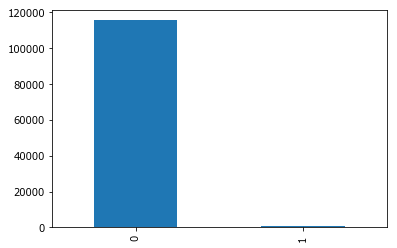

In [5]:
train['m13'].value_counts().plot(kind='bar')

In [6]:
print('Defaulter percentage :', train['m13'].value_counts()[1]/train['m13'].value_counts().sum()*100 , '%')

Defaulter percentage : 0.5480018611383963 %


In [7]:
target = train['m13'] # labels

train.drop(['loan_id','m13'], axis=1, inplace=True)
test.drop('loan_id', axis=1, inplace=True)

In [8]:
cat_cols = ['source', 'financial_institution', 'loan_purpose'] 
date_cols = ['origination_date', 'first_payment_date']
m_cols = ['m1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12']
num_cols = ['interest_rate', 'unpaid_principal_bal', 'loan_term', 'loan_to_value',
       'number_of_borrowers', 'debt_to_income_ratio', 'borrower_credit_score',
       'insurance_percent', 'co-borrower_credit_score']

<a id=2> </a> <br>

## <span style="background:gray;color:red">3. </span><span style="background:yellow;color:blue">OneHotEncoding </span>

In [9]:
def onehotencode(df):
    enc = OneHotEncoder(handle_unknown='ignore')
    df_cat = df[cat_cols]
    enc.fit(df_cat)
    df_cat = pd.DataFrame(enc.transform(df_cat).toarray())
    cat_col2 = df_cat.columns.tolist()
    for i in range(len(cat_col2)):
        cat_col2[i] = 'f' + str(cat_col2[i]) 
    df_cat.columns = cat_col2
    df = pd.concat([df, df_cat], axis=1)
    df.drop(cat_cols, axis=1, inplace=True)
    
    return df,cat_col2  
train, cat_col2  = onehotencode(train)
test, cat_col2  = onehotencode(test)

In [10]:
train.head()

,interest_rate,unpaid_principal_bal,loan_term,origination_date,first_payment_date,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,4.250,214000,360,2012-03-01,05/2012,95,1.0,22.0,694.0,30.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,4.875,144000,360,2012-01-01,03/2012,72,1.0,44.0,697.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.250,366000,180,2012-01-01,03/2012,49,1.0,33.0,780.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,4.750,135000,360,2012-02-01,04/2012,46,2.0,44.0,633.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.750,124000,360,2012-02-01,04/2012,80,1.0,43.0,681.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


<a id=3> </a> <br>

## <span style="background:gray;color:red">4. </span><span style="background:yellow;color:blue">Date Columns Processing </span>

In [11]:
# Remove date columns because most of the dates are same 
train.drop(date_cols, axis=1, inplace=True)
test.drop(date_cols, axis=1, inplace=True)

In [12]:
train.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,4.250,214000,360,95,1.0,22.0,694.0,30.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,4.875,144000,360,72,1.0,44.0,697.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3.250,366000,180,49,1.0,33.0,780.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,4.750,135000,360,46,2.0,44.0,633.0,0.0,638.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,4.750,124000,360,80,1.0,43.0,681.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
test.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,f24
0,3.875,417000,360,75,1,20,790,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,4.500,113000,360,80,2,33,793,0,784,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,4.500,72000,360,75,1,34,710,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4.125,123000,180,41,2,24,798,0,813,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.250,166000,180,53,2,12,767,0,768,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


<a id=4> </a> <br>

## <span style="background:gray;color:red">5. </span><span style="background:yellow;color:blue">Feature Engineering </span>

In [14]:
def feat_eng1(df):
    df['m_mean'] = df[m_cols].mean(axis=1)
    df['m_sum'] = df[m_cols].sum(axis=1)
    df['m_std'] = df[m_cols].std(axis=1)
    
    df['m_new'] = (df['m_mean']*df['m_std'])/df['m_sum']*100
    
    df['num_mean'] = df[num_cols].mean(axis=1)
    df['num_sum'] = df[num_cols].sum(axis=1)
    df['num_std'] = df[num_cols].std(axis=1)
    
    df['num_new'] = df['num_sum']/(df['num_mean']*df['num_std'])
    
    
    df['interest'] = (df['interest_rate']*df['unpaid_principal_bal']*df['loan_to_value'])/(12*100)
    df['dir_lv_nb'] = (df['debt_to_income_ratio']*df['number_of_borrowers'])/(df['loan_to_value'])
    df['total'] = df['unpaid_principal_bal'] + df['interest']
    df['mean_credit_score'] = (df['borrower_credit_score'] + df['co-borrower_credit_score'])/(df['number_of_borrowers'])
    df['bcs_nb_lv'] = (df['mean_credit_score'])/(df['loan_to_value'])
    df['EMI'] = (df['total'])/((df['loan_term']/12))/df['number_of_borrowers']
    df = df.replace(np.nan, 0)
    return df

train = feat_eng1(train)
test = feat_eng1(test)



In [15]:
train.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,num_mean,num_sum,num_std,num_new,interest,dir_lv_nb,total,mean_credit_score,bcs_nb_lv,EMI
0,4.250,214000,360,95,1.0,22.0,694.0,30.0,0.0,0.0,...,23911.805556,215206.250,71283.458512,0.000126,72002.083333,0.231579,286002.083333,694.0,7.305263,9533.402778
1,4.875,144000,360,72,1.0,44.0,697.0,0.0,0.0,0.0,...,16130.986111,145178.875,47951.465225,0.000188,42120.000000,0.611111,186120.000000,697.0,9.680556,6204.000000
2,3.250,366000,180,49,1.0,33.0,780.0,0.0,0.0,0.0,...,40782.916667,367046.250,121956.666318,0.000074,48571.250000,0.673469,414571.250000,780.0,15.918367,27638.083333
3,4.750,135000,360,46,2.0,44.0,633.0,0.0,638.0,0.0,...,15191.972222,136727.750,44928.800940,0.000200,24581.250000,1.913043,159581.250000,635.5,13.815217,2659.687500
4,4.750,124000,360,80,1.0,43.0,681.0,0.0,0.0,0.0,...,13907.750000,125169.750,41285.245614,0.000218,39266.666667,0.537500,163266.666667,681.0,8.512500,5442.222222


In [16]:
test.head()

,interest_rate,unpaid_principal_bal,loan_term,loan_to_value,number_of_borrowers,debt_to_income_ratio,borrower_credit_score,insurance_percent,co-borrower_credit_score,insurance_type,...,num_mean,num_sum,num_std,num_new,interest,dir_lv_nb,total,mean_credit_score,bcs_nb_lv,EMI
0,3.875,417000,360,75,1,20,790,0,0,0,...,46472.208333,418249.875,138948.175777,0.000065,100992.187500,0.266667,517992.187500,790.0,10.533333,17266.406250
1,4.500,113000,360,80,2,33,793,0,784,0,...,12784.055556,115056.500,37582.396029,0.000239,33900.000000,0.825000,146900.000000,788.5,9.856250,2448.333333
2,4.500,72000,360,75,1,34,710,0,0,0,...,8131.611111,73184.500,23951.859554,0.000376,20250.000000,0.453333,92250.000000,710.0,9.466667,3075.000000
3,4.125,123000,180,41,2,24,798,0,813,0,...,13873.569444,124862.125,40923.784479,0.000220,17335.312500,1.170732,140335.312500,805.5,19.646341,4677.843750
4,3.250,166000,180,53,2,12,767,0,768,0,...,18642.805556,167785.250,55259.869808,0.000163,23827.916667,0.452830,189827.916667,767.5,14.481132,6327.597222


In [17]:
train1 = train
test1 = test

<a id=5> </a> <br>

## <span style="background:gray;color:red">6. </span><span style="background:yellow;color:blue">LightGBM </span>

In [18]:
cat_feat = cat_col2 # + m_cols 

In [19]:
# Define F1-Score
def lgb_f1_score(preds, dtrain):
    y_true = dtrain.get_label()
    preds = np.round(preds)
    return 'f1', f1_score(y_true, preds), True

<a id=6> </a> <br>

## <span style="background:gray;color:red">6.1 </span><span style="background:yellow;color:blue">HyperParamters Optimization</span>

### To learn Bayesioan Optimization technique for Hyperparameters Optimization read my [<span style="background:yellow;color:blue">Medium article </span>](https://medium.com/game-of-data/hyperparameters-optimization-for-lightgbm-catboost-and-xgboost-regressors-using-bayesian-6e7c495947a9). 

In [69]:
# Objective Function
train_data = lgb.Dataset(data=train1, label=target, free_raw_data=False)
evals_result = {}
def lgb_eval(num_leaves, feature_fraction, bagging_fraction, max_depth, lambda_l1, lambda_l2, min_split_gain, min_child_weight):
        params = {'application':'binary','num_iterations': 1500,
                  'learning_rate':0.01, 'early_stopping_round':100,
                  'metric':'lgb_f1_score'}
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['lambda_l1'] = max(lambda_l1, 0)
        params['lambda_l2'] = max(lambda_l2, 0)
        params['min_split_gain'] = min_split_gain
        params['min_child_weight'] = min_child_weight
        cv_result = lgb.cv(params, train_data, nfold=5, seed=110,
                           stratified=True,categorical_feature=cat_feat,
                           feval=lgb_f1_score, verbose_eval =None)
        return max(cv_result['f1-mean'])

In [70]:
pbs = {'num_leaves': (130, 210),
        'feature_fraction': (0.1, 0.9),
        'bagging_fraction': (0.8, 1),
        'max_depth': (8, 25),
        'lambda_l1': (0, 3),
        'lambda_l2': (0, 4),
        'min_split_gain': (0.001, 0.1),
        'min_child_weight': (3, 15)
      }

In [71]:
optimizer = BayesianOptimization(lgb_eval, pbs, random_state=7)
optimizer.maximize(init_points=5, n_iter=15, random_state=0)

|   iter    |  target   | baggin... | featur... | lambda_l1 | lambda_l2 | max_depth | min_ch... | min_sp... | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.4949   |  0.8153   |  0.7239   |  1.315    |  2.894    |  24.63    |  9.462    |  0.05061  |  135.8    |
|  2        |  0.4915   |  0.8537   |  0.4999   |  2.038    |  3.215    |  14.48    |  3.791    |  0.02953  |  202.8    |
|  3        |  0.0      |  0.8427   |  0.4617   |  2.794    |  0.0996   |  18.21    |  14.4     |  0.0238   |  173.9    |
|  4        |  0.4961   |  0.9818   |  0.2065   |  1.57     |  3.002    |  19.37    |  8.613    |  0.02128  |  169.3    |
|  5        |  0.4906   |  0.8745   |  0.4819   |  1.098    |  3.352    |  21.07    |  6.768    |  0.05769  |  152.1    |
|  6        |  0.0      |  1.0      |  0.1      |  0.0      |  4.0      |  8.0      |  3.0      |  0.001    |  130.0    |
|  7        |  0.0      

In [72]:
optimizer.max

{'target': 0.4960809678561347,
 'params': {'bagging_fraction': 0.9818256749773463,
  'feature_fraction': 0.20653555660740014,
  'lambda_l1': 1.5702377420212974,
  'lambda_l2': 3.0016394364081393,
  'max_depth': 19.373225095026534,
  'min_child_weight': 8.613034316939768,
  'min_split_gain': 0.021280059939481715,
  'num_leaves': 169.26127112728562}}

In [73]:
p = optimizer.max['params']

In [74]:
param = {'num_leaves': int(round(p['num_leaves'])),
         'feature_fraction': p['feature_fraction'],
         'bagging_fraction': p['bagging_fraction'],
         'max_depth': int(round(p['max_depth'])),
         'lambda_l1': p['lambda_l1'],
         'lambda_l2':p['lambda_l2'],
         'min_split_gain': p['min_split_gain'],
         'min_child_weight': p['min_child_weight'],
         'learing_rate':0.01,
         'objective': 'binary',
         'boosting_type': 'gbdt',
         'verbose': 1,
         'metric': {'lgb_f1_score'},
         'is_unbalance': True,
         'boost_from_average': False}


In [75]:
param

{'num_leaves': 169,
 'feature_fraction': 0.20653555660740014,
 'bagging_fraction': 0.9818256749773463,
 'max_depth': 19,
 'lambda_l1': 1.5702377420212974,
 'lambda_l2': 3.0016394364081393,
 'min_split_gain': 0.021280059939481715,
 'min_child_weight': 8.613034316939768,
 'learing_rate': 0.01,
 'objective': 'binary',
 'boosting_type': 'gbdt',
 'verbose': 1,
 'metric': {'lgb_f1_score'},
 'is_unbalance': True,
 'boost_from_average': False}

<a id=7> </a> <br>

### <span style="background:gray;color:red">6.2 </span><span style="background:yellow;color:blue">Best Iterations</span>

#### Note: <br>
`There is not need to find best iterations when ealry_stopping_rounds parameter is used in model training. `

In [76]:
X_train, X_valid, y_train, y_valid = train_test_split(train1, target, train_size =0.80, random_state=10)

dtrain = lgb.Dataset(X_train, y_train, free_raw_data=False)
dvalid = lgb.Dataset(X_valid, y_valid, free_raw_data=False)
watchlist = [dtrain, dvalid]

[100]	train's f1: 0.768084	val's f1: 0.506757
[200]	train's f1: 0.904302	val's f1: 0.548387
[300]	train's f1: 0.944954	val's f1: 0.550847
[400]	train's f1: 0.953704	val's f1: 0.553191
[500]	train's f1: 0.953704	val's f1: 0.550847
[600]	train's f1: 0.953704	val's f1: 0.550847
[700]	train's f1: 0.953704	val's f1: 0.550847
[800]	train's f1: 0.953704	val's f1: 0.550847
[900]	train's f1: 0.953704	val's f1: 0.550847
[1000]	train's f1: 0.953704	val's f1: 0.550847


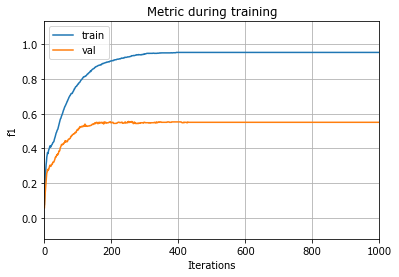

In [77]:
evals_result = {}
param_cv = param
param_cv['n_estimators'] =1000
clf = lgb.train(param_cv, dtrain, valid_sets=watchlist, valid_names=['train', 'val'],categorical_feature=cat_feat,
                feval=lgb_f1_score, evals_result=evals_result, verbose_eval =100)

lgb.plot_metric(evals_result, metric='f1')

<a id=8> </a> <br>

### <span style="background:gray;color:red">6.3 </span><span style="background:yellow;color:blue">Training and Prediction</span>

In [78]:
%%time
nfold = 5
predictors = train1.columns.values.tolist()

skf = StratifiedKFold(n_splits=nfold, shuffle=True, random_state=2010)

oof = np.zeros(len(train1))
predictions = np.zeros(len(test1))

i = 1
for train_index, valid_index in skf.split(train['m12'], train['m12'].values):
    print("fold {}".format(i))
    xg_train = lgb.Dataset(train1.iloc[train_index],
                           label=target[train_index],
                           free_raw_data = False
                           )
    xg_valid = lgb.Dataset(train1.iloc[valid_index],
                           label=target[valid_index],
                           free_raw_data = False
                           )   
    
    clf = lgb.train(param, xg_train, 5000, valid_sets = [xg_valid],
                    categorical_feature=cat_feat,feval=lgb_f1_score,
                    verbose_eval=100, early_stopping_rounds = 200)
    oof[valid_index] = clf.predict(train1.iloc[valid_index], num_iteration=clf.best_iteration) 
    
    predictions += clf.predict(test1[predictors], num_iteration=clf.best_iteration) / nfold
    i = i + 1

print("\n\nCV F1-Score: {:<0.2f}".format(f1_score(target, np.round(oof))))



fold 1
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.444444
[200]	valid_0's f1: 0.504
[300]	valid_0's f1: 0.508333
[400]	valid_0's f1: 0.512605
[500]	valid_0's f1: 0.51046
Early stopping, best iteration is:
[317]	valid_0's f1: 0.514768
fold 2
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.50519
[200]	valid_0's f1: 0.5
[300]	valid_0's f1: 0.517241
[400]	valid_0's f1: 0.519824
[500]	valid_0's f1: 0.519824
Early stopping, best iteration is:
[372]	valid_0's f1: 0.519824
fold 3
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.454849
[200]	valid_0's f1: 0.492188
[300]	valid_0's f1: 0.514523
[400]	valid_0's f1: 0.518828
Early stopping, best iteration is:
[295]	valid_0's f1: 0.522822
fold 4
Training until validation scores don't improve for 200 rounds.
[100]	valid_0's f1: 0.429066
[200]	valid_0's f1: 0.469136
[300]	valid_0's f1: 0.475336
[400]	valid_0's f1: 0.477064
[500]	valid_0's 

In [79]:
predictions

array([0.00588779, 0.00704344, 0.0085025 , ..., 0.13306236, 0.00142022,
       0.00539926])

# Feature Selection 


imp_df = pd.DataFrame()
imp_df["feature"] = list(train1.columns.tolist())
imp_df["importance_gain"] = clf.feature_importance(importance_type='gain')
imp_df["importance_split"] = clf.feature_importance(importance_type='split')
imp_df['trn_f1_score'] = f1_score(target, np.round(clf.predict(train1)))

imp_df.head()

imp_df = imp_df.sort_values(by='importance_gain', ascending=False).reset_index(drop=True)
print(imp_df.head(10))
important_feat_gain = imp_df['feature'][:10].tolist()

imp_df = imp_df.sort_values(by='importance_split', ascending=False).reset_index(drop=True)
print(imp_df.head(10))
important_feat_split = imp_df['feature'][:10].tolist()

imp_df['importance'] = imp_df['importance_gain']*imp_df['importance_split']
imp_df = imp_df.sort_values(by='importance', ascending=False).reset_index(drop=True)
print(imp_df.head(35))
imp_feats = imp_df['feature'][:35].tolist()

train1 = train[imp_feats]
test1 = test[imp_feats]

<a id=9> </a> <br>

### <span style="background:gray;color:red">6.4 </span><span style="background:yellow;color:blue">Submission DataFrame</span>

In [80]:
sub = pd.read_csv('data/sample_submission.csv')

In [81]:
sub['m13'] = predictions

sub['m13'] = sub['m13'].apply(lambda x:1 if x>=0.50 else 0)

sub['m13'].value_counts()

0    35710
1      156
Name: m13, dtype: int64

In [82]:
print('Defaulter percentage :', sub['m13'].value_counts()[1]/sub['m13'].value_counts().sum()*100 , '%')

Defaulter percentage : 0.43495232253387606 %


In [83]:
sub.to_csv('submission.csv', index=False)



## <center><span style="background:gray;color:red">End of the NoteBook</span></center>
***

### <center><span style="background:yellow;color:blue">[GO TO TOP](#000)</span></center> 